In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of 01060602previewen-02d.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_3.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Sample13.150.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image16 (3).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_4.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of image17 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of close-up-of-alluvial-soil-as-a-texturebackground-JCB3RY.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_6 - Copy.jpg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image15 (2).jpeg
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Alluvial_26.png
/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/image16 (

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
def preprocess_image(image_path):
    """ Load and preprocess an image: CLAHE, RGB & HSV extraction, resizing, and normalization """
    image = cv2.imread(image_path)

    # Convert to grayscale and apply CLAHE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)

    # Convert to HSV and extract Value (V) channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:, :, 2]

    # Extract RGB channels
    r, g, b = cv2.split(image)
    
    # Blend V-channel into RGB
    r = cv2.addWeighted(r, 0.7, v_channel, 0.3, 0)
    g = cv2.addWeighted(g, 0.7, v_channel, 0.3, 0)
    b = cv2.addWeighted(b, 0.7, v_channel, 0.3, 0)

    # Merge back to RGB
    processed_image = cv2.merge([r, g, b])
    processed_image = cv2.resize(processed_image, (224, 224))

    return processed_image / 255.0  # Normalize


In [4]:
def load_dataset(directory):
    """ Load dataset, apply preprocessing, and return images & labels """
    images, labels = [], []
    class_names = sorted(os.listdir(directory))  
    class_dict = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            images.append(preprocess_image(img_path))
            labels.append(class_dict[class_name])
    
    return np.array(images), np.array(labels), class_dict

In [5]:
# Load datasets
train_images, train_labels, class_dict = load_dataset("/kaggle/input/soil-types-dataset/Dataset/Train")
test_images, test_labels, _ = load_dataset("/kaggle/input/soil-types-dataset/Dataset/test")

print("\nClass Label Mapping:")
for class_name, label in class_dict.items():
    print(f"{label}: {class_name}")

num_classes = len(class_dict)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)


Class Label Mapping:
0: Alluvial soil
1: Black Soil
2: Clay soil
3: Red soil


In [6]:
# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [7]:
# Load EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Learning Rate Scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

In [9]:
# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Training
epochs = 30
batch_size = 32
history = model.fit(data_gen.flow(train_images, train_labels, batch_size=batch_size), epochs=epochs)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6197 - loss: 1.1197
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.8746 - loss: 0.3344
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.9042 - loss: 0.2890
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.8993 - loss: 0.2763
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.9325 - loss: 0.2429
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.9445 - loss: 0.1829
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.9452 - loss: 0.1522
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.9707 - loss: 0.1201
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.9569 - loss: 0.1374
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.9623 - loss: 0.1184
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 256ms/step - accuracy: 0.9548 - loss: 0.1155
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step -

In [11]:
# Save Model
model.save("efficientnet_soil_model.h5")

In [12]:
# Print Training Accuracy
final_train_acc = history.history['accuracy'][-1] * 100
print(f"Final Training Accuracy: {final_train_acc:.2f}%")


Final Training Accuracy: 98.02%


In [13]:
# Load Model for Testing
test_model = tf.keras.models.load_model("efficientnet_soil_model.h5")

# Evaluate on Test Data
test_loss, test_acc = test_model.evaluate(test_images, test_labels)
print(f"Final Testing Accuracy: {test_acc * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 529ms/step - accuracy: 0.9630 - loss: 0.1729
Final Testing Accuracy: 97.94%


In [14]:
# Prediction & Confusion Matrix
y_pred = np.argmax(test_model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step


In [16]:
# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_dict.keys()))


Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.98      0.94      0.96        53
   Black Soil       1.00      0.97      0.99       116
    Clay soil       0.94      0.98      0.96        65
     Red soil       0.98      1.00      0.99       106

     accuracy                           0.98       340
    macro avg       0.98      0.98      0.98       340
 weighted avg       0.98      0.98      0.98       340



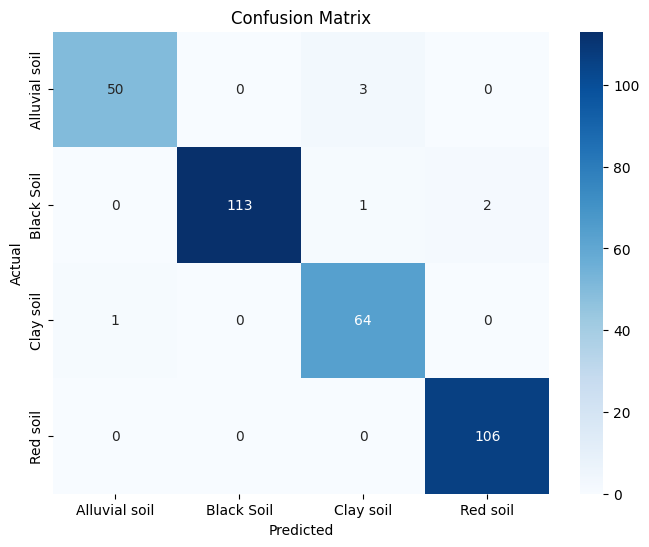

In [23]:

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_dict.keys(), yticklabels=class_dict.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


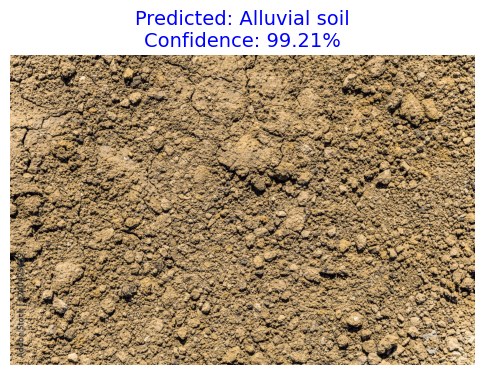


Prediction: Alluvial soil (99.21%)


In [45]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    """ Predict the class of a given soil image and display it with the prediction. """
    # Load and preprocess the image
    image = preprocess_image(image_path)  # Apply preprocessing
    image_batch = np.expand_dims(image, axis=0)  # Add batch dimension

    # Get prediction
    predictions = test_model.predict(image_batch)
    predicted_class = np.argmax(predictions)  # Get class index
    class_name = list(class_dict.keys())[predicted_class]  # Convert index to class name
    confidence = np.max(predictions) * 100  # Confidence score

    # Display the image along with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB for correct display
    plt.axis('off')
    plt.title(f"Predicted: {class_name}\nConfidence: {confidence:.2f}%", fontsize=14, color='blue')
    plt.show()

    print(f"\nPrediction: {class_name} ({confidence:.2f}%)")
example_image = "/kaggle/input/soil-types-dataset/Dataset/test/Alluvial soil/Copy of 1000_F_240425429_YL91trtDxXQl8L0OKP7zyngeSb63olAC.jpg"  # Replace with an actual image path
predict_image(example_image)